# IEEE-CIS Fraud Detection

## Integrating machine learning to detect fraud

Industries and individuals are suffering from fraudulent damages. Implementing effective and accurate fraud prevention systems can save businesses and consumers millions of dollars. With the goal of improving customer experience, [IEEE Computational Intelligence Society](https://cis.ieee.org/) has partnered with payment service company, [Vesta Corporation](https://trustvesta.com/), to find more effective solutions for fraud prevention. 

In this project, we will be participating in this competition and using Kaggle's competition [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection) machine dataset. The purpose of the competition is to use historical Vesta's real-world e-commerce transaction to predict whether a transaction is fraud or not. We will employ supervised classification models for this task. 
 * __Supervised__: The goal is to train a model to learn from features to predict the probability of an online fraudulent transaction given labels in the _isFraud_ column. 
 * __Classification__: The label is a binary variable: 0 (not fraud), 1 (fraud)
 
### Overview of Data
This dataset contains two files, _identity_ and _transaction_, which are joined by _TransactionID_. Not all transactions have corresponding identity information.

__Categorical Features - Transaction__
 * ProductCD
 * card1 - card6
 * addr1, addr2
 * P_emaildomain
 * R_emaildomain
 * M1 - M9
 
__Categorical Features - Identity__
 * DeviceType
 * DeviceInfo
 * id_12 - id_38
 
The _TransactionDT_ feature is a timedelta from a given reference datetime (not an actual timestamp).

In this notebook, we will be use all identity and transaction files to train and test our model. 

## Metric ROC AUC

Before we begin, let's get an understanding of how each submission is evaluated. For this competition, models are being judged by the Receiver Operating Characteristic Area Under the Curve (ROC AUC), which measures the true positive rate versus the false positive rate. 

ROC AUC measures the probability between 0 and 1. While a score of 0.5 indicates random guessing, better models will receive a higher score. Setting accuracy as the metric isn't recommend since real-world datasets have imbalanced classes. The model will likely be good in predicting the dominant class and misclassify the minority class. In this project, we can anticipate that most transactions are not fraud. If we were to measure based on accuracy, our model would preform well in detecting non-fraud related transactions. That wouldn't be the most effective way in preventing fraud if our model is not good at identifying it. Thus, ROC AUC is used to reflect the accuracy of a classifier.

## Read in Data

There are a total of 5 files: 
 * 1 example submission files 
 * 2 transaction files (test and train)
 * 2 identity files (test and train) 

Since the transaction files include our target variable _isFraud_ column, we will predominately be exploring transaction files. 

In [1]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics tools
import scipy.stats as stats

# Model prep and Modeling 
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

# Decision Trees
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
import pydotplus
import graphviz

# Random Forests 
from sklearn import ensemble

# SVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Evaluate
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

# Import data
from sqlalchemy import create_engine
import warnings

In [2]:
# List files available
test_iden = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/test_identity.csv')
test_trans = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/test_transaction.csv')
train_iden = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/train_identity.csv')
train_trans = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/train_transaction.csv')


In [3]:
# Format column headings 
test_iden.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')
test_trans.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')
train_iden.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')
train_trans.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

Index(['transactionid', 'isfraud', 'transactiondt', 'transactionamt',
       'productcd', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'v330', 'v331', 'v332', 'v333', 'v334', 'v335', 'v336', 'v337', 'v338',
       'v339'],
      dtype='object', length=394)

In [4]:
# Training data
print('Training transaction data shape: ', train_trans.shape)
train_trans.head()

Training transaction data shape:  (590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 590,540 observations (each one a separate online transaction) and 394 attributes including the target variable we want to predict.

In [5]:
print('Testing transaction data shape: ', test_trans.shape)
test_trans.head()

Testing transaction data shape:  (506691, 393)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The testing data contains 506,691 observations and 393 attributes. This dataset is smaller than the training set and does not contain the target variable. 

#### Merging training sets
The transaction training file lacks identity information on each transaction, so we will merge the training identity and transaction files on _TransactionID_. Since each observation has a unique transaction ID, we will do a 1 to 1 join. 

Below, we can see that the row length for train transaction and identity are not equal. It was noted that Vesta was unable to obtain all identity information so we will continue with the merge table for now. 

In [6]:
print('Number of row in transaction:', len(train_trans))
print('Number of row in identity:', len(train_iden))

Number of row in transaction: 590540
Number of row in identity: 144233


In [7]:
# Train data 
df = pd.merge(train_iden, train_trans, on = 'TransactionID')

### Column Types
In this section, we will take a look at the numbers of columns of each data type. 

In [8]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144233 entries, 0 to 144232
Data columns (total 434 columns):
TransactionID     144233 non-null int64
id_01             144233 non-null float64
id_02             140872 non-null float64
id_03             66324 non-null float64
id_04             66324 non-null float64
id_05             136865 non-null float64
id_06             136865 non-null float64
id_07             5155 non-null float64
id_08             5155 non-null float64
id_09             74926 non-null float64
id_10             74926 non-null float64
id_11             140978 non-null float64
id_12             144233 non-null object
id_13             127320 non-null float64
id_14             80044 non-null float64
id_15             140985 non-null object
id_16             129340 non-null object
id_17             139369 non-null float64
id_18             45113 non-null float64
id_19             139318 non-null float64
id_20             139261 non-null float64
id_21             515

In this dataframe, there are 403 numeric variables and 31 categorical variables. Due to privacy protection, column names have been changed which makes it more difficult to comperhend the information in each column. 

We will revisit the data summary given by Vesta to better understand our data. 

__Transaction__<br>

_Categorical Features_
 * ProductCD: product code
 * card1 - card6: card information 
 * addr1, addr2: address 
 * P_emaildomain: purchaser email domain
 * R_emaildomain: recipient email domain
 * M1 - M9: match (names on card, address, etc)
 
_Numeric Features_
 * dist: distance
 * C1-C4: counting
 * D1-D15: timedelta (time between previous transaction)
 * V1-V339: Vesta engineered features
 * TransactionDT: timedelta from a given reference datetime
 * TransactionAMT: transaction payment amount in USD
 
__Identity__
 * DeviceType
 * DeviceInfo
 * id_12 - id_38: contains network connection information 

In [9]:
# Number of unique classes in each object column
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

id_12               2
id_15               3
id_16               2
id_23               3
id_27               2
id_28               2
id_29               2
id_30              75
id_31             130
id_33             260
id_34               4
id_35               2
id_36               2
id_37               2
id_38               2
DeviceType          2
DeviceInfo       1786
ProductCD           4
card4               4
card6               3
P_emaildomain      59
R_emaildomain      60
M1                  0
M2                  0
M3                  0
M4                  3
M5                  0
M6                  0
M7                  0
M8                  0
M9                  0
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables!

### Missing Values
Now, we will take a look at missing values in each column. Due to the volume of the data, we will look at different sections of the data.

In [10]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [11]:
missing_values_table(df)

Your selected dataframe has 434 columns.
There are 412 columns that have missing values.


,Missing Values,% of Total Values
V11,144233,100.0
M9,144233,100.0
D11,144233,100.0
V8,144233,100.0
V7,144233,100.0
V6,144233,100.0
V5,144233,100.0
V4,144233,100.0
V9,144233,100.0
V2,144233,100.0


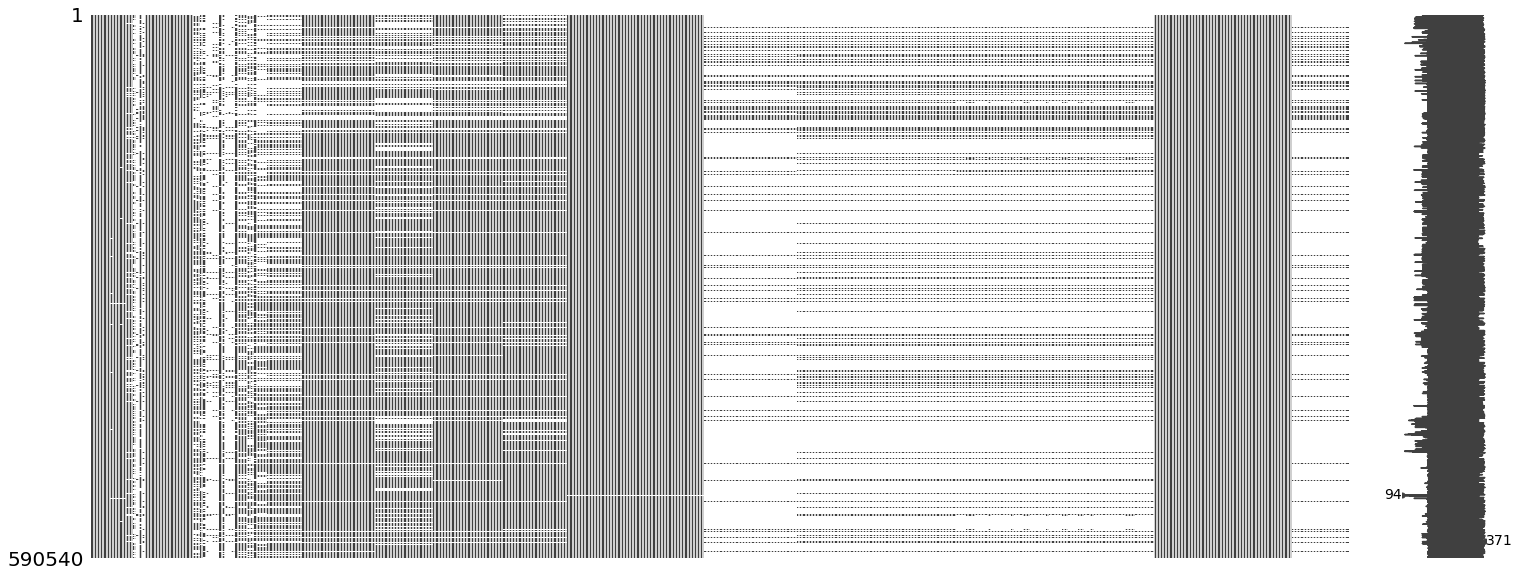

In [12]:
msno.matrix(train_trans)

We can observe that there are missing values in majority of the columns. There appears to be a pattern of missing values in columns V122-V163. Due to  the limited information given on these columns for privacy issues, it is difficult to determine if these columns offer helpful information for predicting fraud.

Let's first take a look at the missing data for categorical variables. 

In [13]:
# Catgorical variables 
df_cat = df.filter(regex='id|card|ProductCD|addr|email|M|DeviceType|DeviceInfo')

In [14]:
missing_values_table(df_cat)

Your selected dataframe has 60 columns.
There are 56 columns that have missing values.


,Missing Values,% of Total Values
M9,144233,100.0
M1,144233,100.0
M2,144233,100.0
M3,144233,100.0
M5,144233,100.0
M6,144233,100.0
M8,144233,100.0
M7,144233,100.0
id_24,139486,96.7
id_25,139101,96.4


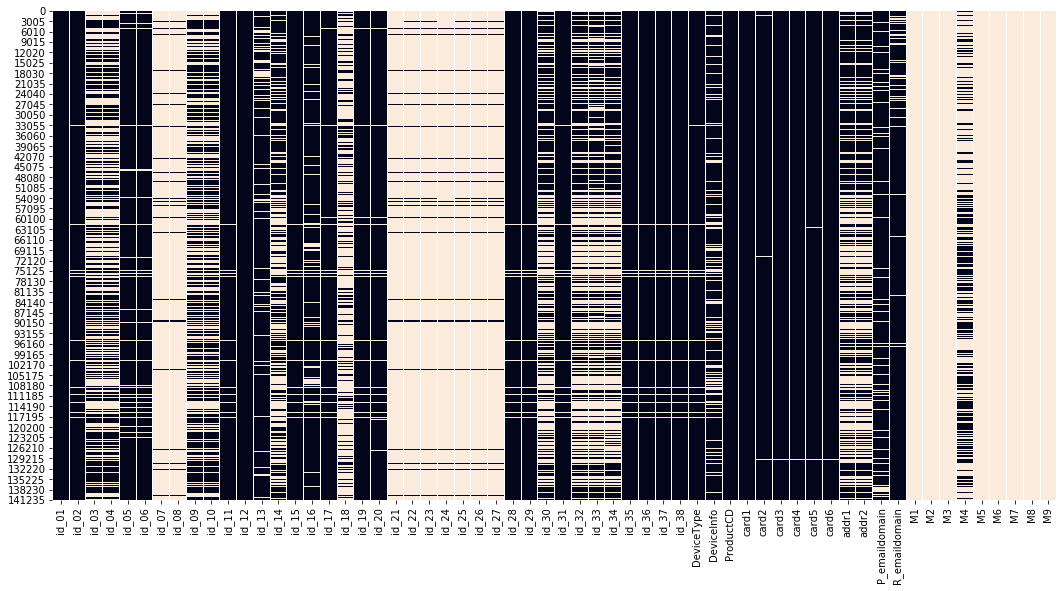

In [15]:
plt.figure(figsize=(18,9))
sns.heatmap(df_cat.isnull(), cbar= False)

It appears that most of M columns are completely missing data expecet M4. The transaction system may only required one match of identification to carry out the transaction so other matching information was not collected. 

Columns Id_07, 08, and id_21-27 are missing 90% of data. Vesta may not been able to collect network connection information due to privacy protection. 

Now, let's continue to look at numerical variables. 

In [16]:
# Numerical variables
df_num = df.filter(regex='isFraud|TransactionDT|TransactionAmt|dist|C|D')

In [17]:
missing_values_table(df_num)

Your selected dataframe has 38 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
D11,144233,100.0
dist1,144233,100.0
D3,115174,79.9
D2,113117,78.4
D5,111158,77.1
D7,108093,74.9
dist2,106640,73.9
D12,85324,59.2
D13,82297,57.1
D14,82068,56.9


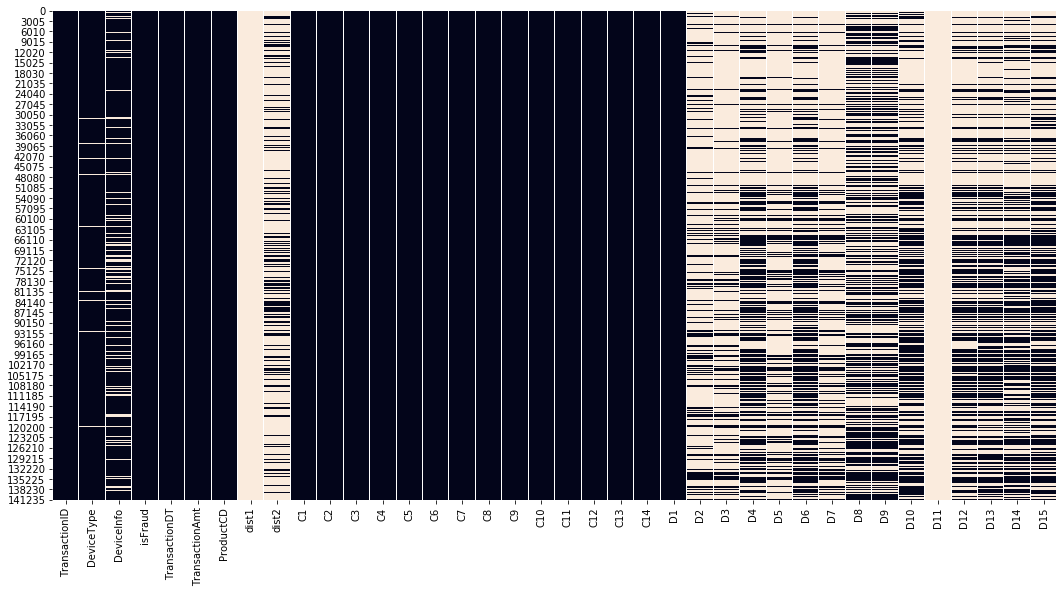

In [18]:
plt.figure(figsize=(18,9))
sns.heatmap(df_num.isnull(), cbar= False)

Not much information regarding the distance (dist1 and dist2) between each transaction was obtained. 

Most of D columns regarding timedelta between previous purchase are also spare expect D1. 

As first explored in the full missing data table, let's Vesta's engineered features (V columns) which had the most missing values. 

In [19]:
# Vesta columns 
df_ves = df.filter(regex='V')

In [20]:
missing_values_table(df_ves)

Your selected dataframe has 339 columns.
There are 339 columns that have missing values.


,Missing Values,% of Total Values
V1,144233,100.0
V7,144233,100.0
V2,144233,100.0
V11,144233,100.0
V9,144233,100.0
V8,144233,100.0
V10,144233,100.0
V6,144233,100.0
V5,144233,100.0
V4,144233,100.0


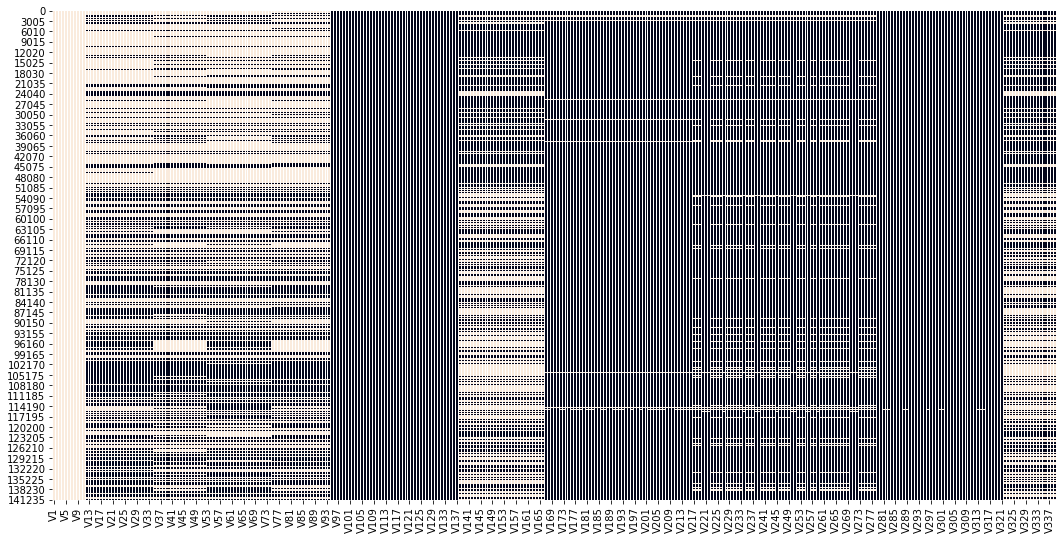

In [21]:
plt.figure(figsize=(18,9))
sns.heatmap(df_ves.isnull(), cbar= False)

We can see that there is a pattern in missing data for V columns. There appears to be clusters of columns that have missing data at the same rows. The V columns might have been designed to describe characteristics of transaction. If the orginal column did not have data, then the engineered columns were also left blank. 

### Dealing with Missing Values

There is no perfect way to deal with missing values. As discovered by looking at V columns, the data is probably not missing at random since there is a pattern certain values missing in the same location of across multiple columns. 

Since there are over 400 columns with missing values, we will drop columns that are missing 90% of data. For the remaining variables, we will impute categorical variables by mode and numerical variables by mean. 

In [22]:
# Get columns with >= 90% missing
missing_df = missing_values_table(df)
missing_columns = list(missing_df[missing_df['% of Total Values'] >= 90].index)
print('We will drop %d columns.' % len(missing_columns))

Your selected dataframe has 434 columns.
There are 412 columns that have missing values.
We will drop 30 columns.


In [23]:
# Drop 30 columns with 90% missing values
df2 = df.copy()
df2 = df.drop(missing_columns, axis=1)

In [24]:
# Get categorical columns with missing values
df2_cat = df2.select_dtypes(include=['object'])
missing_df = missing_values_table(df2_cat)
missing_columns = list(missing_df.index)
print('We will impute %d columns.' % len(missing_columns))

Your selected dataframe has 21 columns.
There are 19 columns that have missing values.
We will impute 19 columns.


In [25]:
# Imputation by mode
df2[missing_columns] = df2[missing_columns].fillna(df2.mode().iloc[0])

In [ ]:
# Imputation by mean 
df2 = df2.fillna(df2.mean())

In [ ]:
df2.head()

## Exploratory Data Analysis 
Exploratory Data Analysis (EDA) is an iterative process to explore the data and summarize characteristics by calculating statistics or visualize methods. The purpose of EDA is gain an understanding of the data by identifying trends, anomalies, or relationships that might be helpful when making decisions in the modeling process. 

### Univariate Analysis

We will begin EDA by exploring individual variables, particularly our target variable, _isFraud_. The target is what we are asked to predict: either a 0 for non-fraud transactions, or a 1 for fraud transaction. First, let's examine the number of transactions falling into each category.

In [ ]:
df['isFraud'].value_counts()

In [ ]:
# Plot target variable
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'isFraud', data = df)
g.set_title("Fraud Distribution", fontsize = 17)
g.set_xlabel("Is Fraud?", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
plt.legend(title='Fraud', labels=['No', 'Yes'])

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(df) * 100),
            ha="center", fontsize=15) 

We can see an imbalanced class problem from the value count and histogram. Majority of transactions were non-fraudlent transactions. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

### Anomalies 
We'll be searching for anomalies within the data.  These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method. 

In [ ]:
# Categorical Statistics 
df_cat.describe()

COMMENT on statistics

### Multivariable Analysis
Now, let's explore how our target variable interacts with other features. We'll start with exploring categorical variables. 



### Correlation 
To determine which explanatory variables we might select for our prediction model, we will explore the correlation between _isFraud_ and other variables. Correlation refers to a mutal association between variables. Variables that have a strong correlation, whether it being positive or negative, will affect the target variable.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

.00-.19 “very weak”
.20-.39 “weak”
.40-.59 “moderate”
.60-.79 “strong”
.80-1.0 “very strong”

In [ ]:
# Find correlations with the target and sort
corr = df.corr()['isFraud'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', corr.tail(15))
print('\nMost Negative Correlations:\n', corr.head(15))

Let's take a look at some of more significant correlations:

#### Product CD

In [ ]:
# Plot Product CD Distribution 
plt.figure(figsize=(12,6))

total = len(df_cat)

plt.subplot(1,2,1)
g = sns.countplot(x = 'ProductCD', data = df_cat)
g.set_title('ProductCD Distribution', fontsize = 15)
g.set_xlabel("Product Code", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(1,2,2)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df)
g1.set_title('ProductCD by Fraud', fontsize = 15)
g1.set_xlabel("Product Code", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

Product Code C was the most occuring product category and had the highest count of fraud. 

In [ ]:
df[df['isFraud'] == 1]['ProductCD'].value_counts(normalize = True)

Product C makes up 67% of transaction fraud cases. That is more than double the amount of fraud for other product categories. 

In [ ]:
plt.figure(figsize=(12,10))
sns.boxplot(x = 'ProductCD', y = 'TransactionAmt', hue = 'isFraud', data = df)

Product C items cost less than other product code items. 

#### Examine Card Type
The card 1,2,3, and 5 was represented as numerical values, temping us to plot the histogram. However, we need to remember that card columns were classified as categorical variables. Meaning it's likely that these numerical variables were coded for categorical variables.

In [ ]:
df_cat.loc[:,'card1':'card5'].nunique()

In [ ]:
# Plot Card 4
plt.figure(figsize=(12,6))

total = len(df_cat)

plt.subplot(121)
g = sns.countplot(x = 'card4', data = df_cat)
g.set_title('Card Network Distribution', fontsize = 15)
g.set_xlabel("Card Issuers", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card4', hue='isFraud', data=df)
g1.set_title('Card Network by Fraud', fontsize = 15)
g1.set_xlabel("Card Issuers", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

Visa card accounts for the highest instances of fraud, but this also because visa is the most popular card type.

In [ ]:
df[df['isFraud'] == 1]['card4'].value_counts(normalize = True)

In [ ]:
df.groupby('card4')['isFraud'].value_counts(normalize = True)

Visa accounts for 61% of all fraud occurences. However, when normalized by total number of each type, Visa have fraud rate of only 8%, lower than Mastercard and same as Discovercard. Only American Express have significantly lower fraud rate compare to others.

In [ ]:
# Card 6
plt.figure(figsize=(12,6))

total = len(df_cat)

plt.subplot(121)
g = sns.countplot(x = 'card6', data = df)
g.set_title('Card Type Distribution', fontsize = 15)
g.set_xlabel("Card Type", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card6', hue='isFraud', data=df)
g1.set_title('Card Type by Fraud', fontsize = 15)
g1.set_xlabel("Card Type", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

In [ ]:
df.groupby('card6')['isFraud'].value_counts(normalize = True)

The number of card type are fairly simiar, and so does the fraud cases

### Examine Email Domain

In [ ]:
# Plot email domain
plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_emaildomain', data = df)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation='vertical')

In [ ]:
P_emaildomain_fraud_rate = df.groupby('P_emaildomain')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]
plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_emaildomain', data = df)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = P_emaildomain_fraud_rate.index, y = P_emaildomain_fraud_rate, color = 'blue')
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")

Protonmail returns an exemely high fraud rate. Almost 80% of transactions from purchaser using protonmail.com were label fraud.

### Recipient Email


In [ ]:
R_emaildomain_fraud_rate = df.groupby('R_emaildomain')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'R_emaildomain', data = df, order = R_emaildomain_fraud_rate.index)
g.set_title('Recipient Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = R_emaildomain_fraud_rate.index, y = R_emaildomain_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")

Similar to Email Domain, protonmail recieved the most fraud rate.

### Examine M1-M9

In [ ]:
def visualize_cat_cariable(variable, df=df):
    df[variable].fillna("NA", inplace=True)
    variable_fraud_rate = df.groupby(variable)['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]
    
    plt.figure(figsize=(12,6))

    g = sns.countplot(x = variable, data = df, order = variable_fraud_rate.index)
    g.set_title('{} Count'.format(variable), fontsize = 15)
    g.set_xlabel("{}".format(variable), fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    plt.xticks(rotation= "vertical")

    r = g.twinx()
    r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
    r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")

In [ ]:
visualize_cat_cariable('M4')

Not much variation in fraud rate between M0, M1, and M2 in M4

### Examine Device Type

In [ ]:
visualize_cat_cariable('DeviceType')

Fraud rate is higher for mobile device compared to desktop

### Examine Device Info

In [ ]:
visualize_cat_cariable('DeviceInfo')

## Feature Engineering and Selection

Since we have identified trends and relationship within the dataset, we will out findings to select a set of features for our model. 

### Add New Features 